In [1]:
from time import time
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

# 1. Forward vs Reverse KL vs JSD

In [2]:
def get_gaussian_log_prob_fn(mu, sigma):
    d = torch.distributions.normal.Normal(mu, sigma)
    fn = lambda x: d.log_prob(x)
    return fn

In [3]:
X = torch.from_numpy(np.linspace(-6,6,500)).double()


In [4]:
single_gaussian = get_gaussian_log_prob_fn(mu=0, sigma=1)

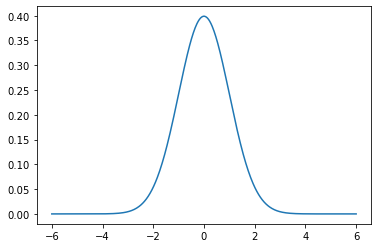

In [5]:
plt.plot(X.numpy(), single_gaussian(X).exp().numpy())


In [12]:
def get_gaussian_mixture_log_prob_fn():
    # define a mixture of gaussians
    k = 0.8
    a = get_gaussian_log_prob_fn(-2, 0.5)
    b = get_gaussian_log_prob_fn(2, 0.5)
 
    fn = lambda x: torch.log(k * a(x).exp() + (1 - k) * b(x).exp())
    return fn

In [13]:
def plot_distributions(X, real_log_prob, model_log_prob=None, title=None, figsize=None, savepath=None):
    with torch.no_grad():
        res1 = real_log_prob(X).exp()
        if model_log_prob is not None:
            res2 = model_log_prob(X).exp()

    if figsize is None:
        figsize = (5, 5)
    plt.figure(figsize=figsize)    
    plt.plot(X.numpy(), res1.numpy(), color='b', linewidth=3, label=r'$\pi(\mathbf{x})$')
    plt.fill_between(X.numpy(), np.zeros_like(X.numpy()), res1.numpy(),  color='b', alpha=0.2)
    if model_log_prob is not None:
        plt.plot(X.numpy(), res2.numpy(), 'g', linewidth=3, label=r'$p(\mathbf{x} | \mu, \sigma)$')
        plt.fill_between(X.numpy(), np.zeros_like(X.numpy()), res2.numpy(),  color='g', alpha=0.2)
    if title is not None:
        plt.title(title, fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

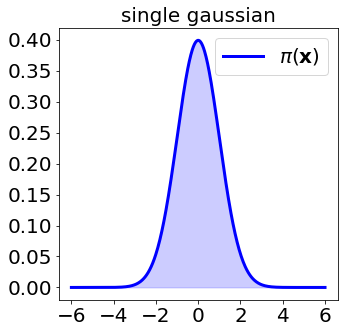

In [14]:
mixture_gaussian = get_gaussian_mixture_log_prob_fn()
plot_distributions(X, single_gaussian, title='single gaussian')

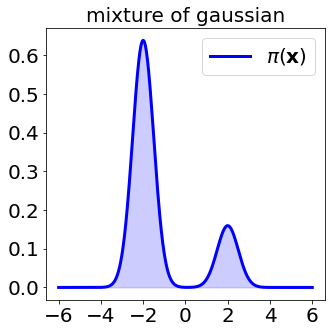

In [15]:
plot_distributions(X, mixture_gaussian, title='mixture of gaussian')

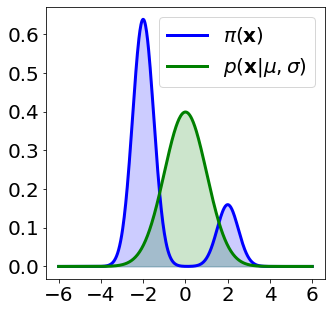

In [16]:

plot_distributions(X, mixture_gaussian, single_gaussian)

In [17]:
def KLD(X, log_prob1, log_prob2):
    # p and q return log pdf
    # X - some linspace
    return (log_prob1(X).exp() * (log_prob1(X) - log_prob2(X))).sum() * (X.max() - X.min()) / len(X)

In [18]:
def JSD(X, log_prob1, log_prob2):
    
    def log_prob_mean(x):
        prob_mean = (log_prob1(x).exp() + log_prob2(x).exp()) / 2
        return prob_mean.log()
    
    return (KLD(X, log_prob1, log_prob_mean) + KLD(X, log_prob2, log_prob_mean)) / 2

In [19]:
forward_KL_loss_fn = lambda X, real_log_prob, model_log_prob: KLD(X, real_log_prob, model_log_prob)
reverse_KL_loss_fn = lambda X, real_log_prob, model_log_prob: KLD(X, model_log_prob, real_log_prob)
JSD_loss_fn = lambda X, real_log_prob, model_log_prob: JSD(X, real_log_prob, model_log_prob)

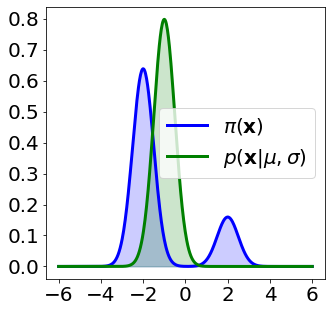

In [20]:
mu_start = -1
sigma_start = 0.5

# define trainable params
mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = get_gaussian_log_prob_fn(mu, sigma)

plot_distributions(X, mixture_gaussian, single_gaussian)

In [21]:
def solve_task(optimizer, loss_fn, real_log_prob, model_log_prob, n_iters):
    for it in range(n_iters):
        optimizer.zero_grad()

        loss = loss_fn(X, real_log_prob, model_log_prob)
        loss.backward()
        optimizer.step()

        if it % 5 == 0: 
            plot_distributions(X, mixture_gaussian, single_gaussian, title=f'step: {it}, loss: {loss:.2f}')

In [22]:
def solve_task(optimizer, loss_fn, real_log_prob, model_log_prob, n_iters):
    for it in range(n_iters):
        optimizer.zero_grad()

        loss = loss_fn(X, real_log_prob, model_log_prob)
        loss.backward()
        optimizer.step()

        if it % 5 == 0: 
            plot_distributions(X, mixture_gaussian, single_gaussian, title=f'step: {it}, loss: {loss:.2f}')

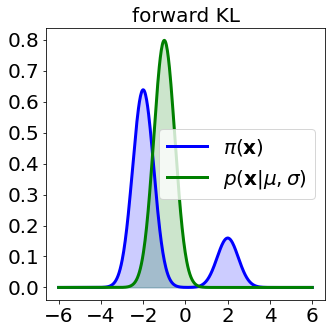

In [23]:
plot_distributions(
    X, 
    mixture_gaussian, 
    single_gaussian, 
    title='forward KL', 
    #savepath='forward_KL.png'
)

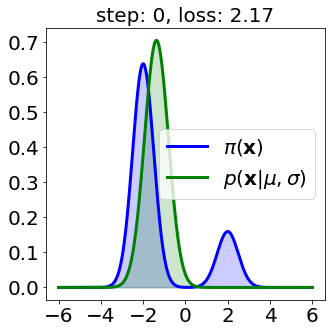

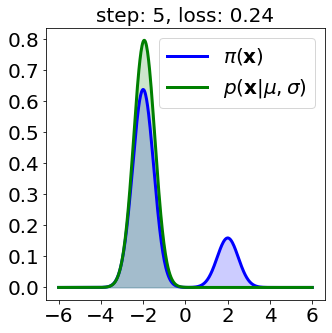

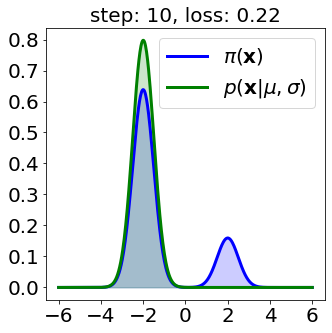

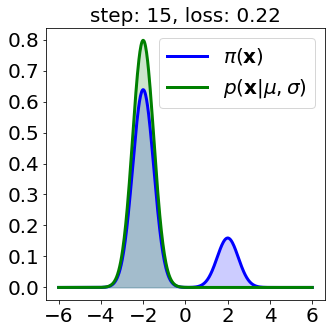

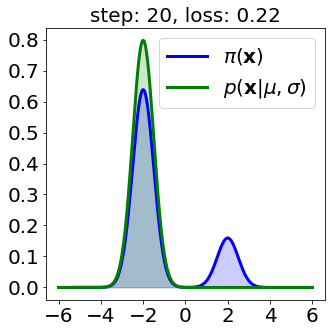

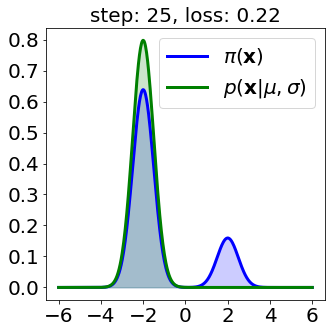

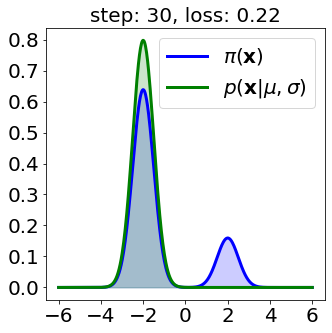

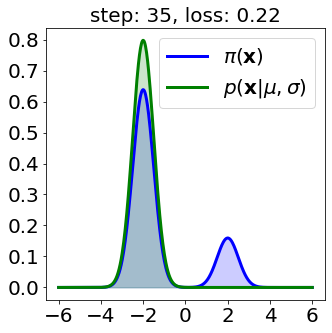

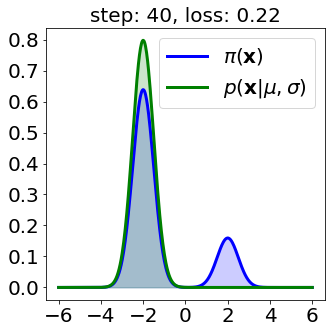

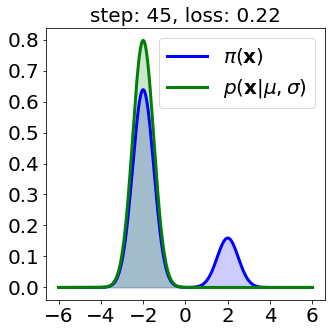

In [24]:
N_ITERS = 50
LEARNING_RATE = 1e-1

mu_start = -1
sigma_start = 0.5

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = get_gaussian_log_prob_fn(mu, sigma)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, reverse_KL_loss_fn, mixture_gaussian, single_gaussian, N_ITERS)

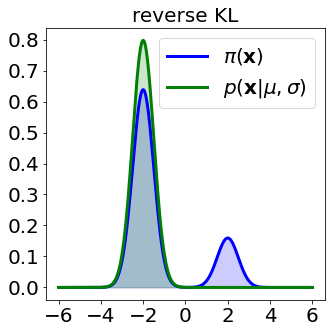

In [25]:
plot_distributions(
    X, 
    mixture_gaussian, 
    single_gaussian, 
    title='reverse KL', 
    #savepath='reverse_KL.png'
)

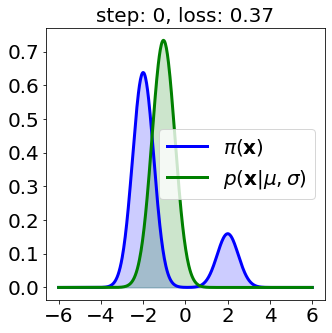

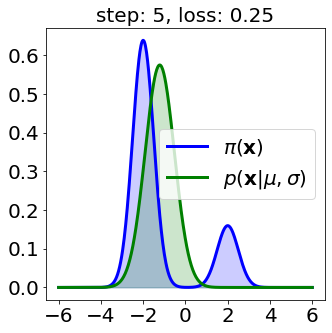

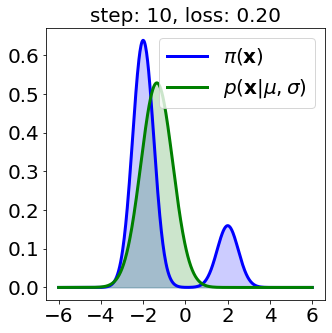

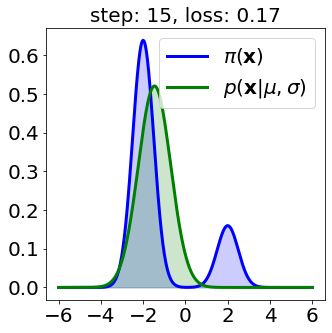

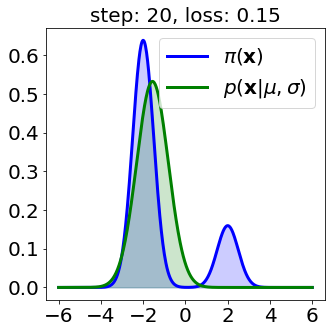

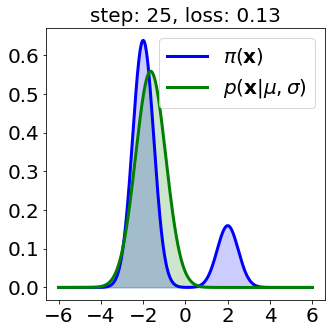

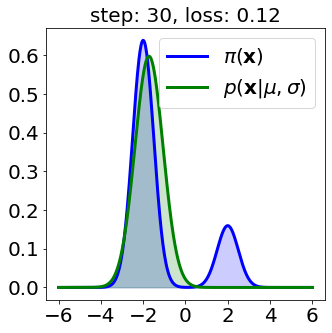

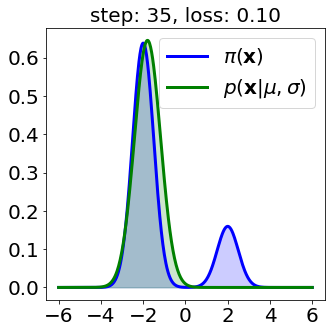

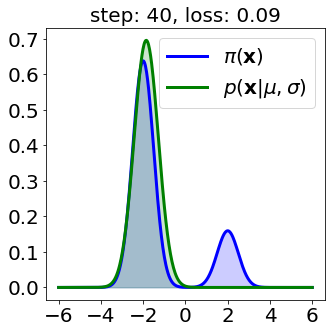

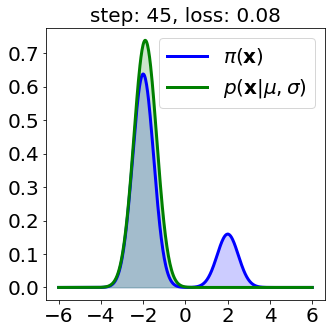

In [26]:
N_ITERS = 50
LEARNING_RATE = 0.1

mu_start = -1
sigma_start = 0.5

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = get_gaussian_log_prob_fn(mu, sigma)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, JSD_loss_fn, mixture_gaussian, single_gaussian, N_ITERS)

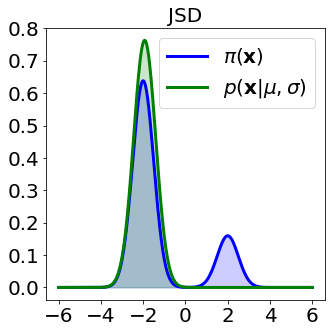

In [27]:
plot_distributions(
    X, 
    mixture_gaussian, 
    single_gaussian, 
    title='JSD', 
    #savepath='JSD.png'
)